In [40]:
from mxnet import  ndarray as nd
import matplotlib.pyplot as plt
import  random
from mxnet import autograd

num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

#init ndarray
X = nd.random_normal(shape = (num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape = y.shape)

#show function
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.show()

In [56]:
#contruct random generator
batch_size = 10

def data_iter():
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i : min(i + batch_size, num_examples)])
        yield nd.take(X, j), nd.take(y, j)

In [57]:
#read random data
for data, label in data_iter():
    print(data, label)
    break


(
[[ 1.0441672   0.56061524]
 [-0.3198779   0.9075743 ]
 [-0.8816921  -0.180835  ]
 [-1.509315    0.8842307 ]
 [ 0.67037326  1.563943  ]
 [ 0.5734874  -1.0383207 ]
 [ 1.915245   -0.33728135]
 [-0.35506797 -0.53655607]
 [-0.7129274  -0.19359757]
 [ 0.01435737 -0.31545097]]
<NDArray 10x2 @cpu(0)>, 
[ 4.375476    0.48183906  3.05817    -1.8222471   0.21968167  8.853382
  9.185796    5.323526    3.4239109   5.2920985 ]
<NDArray 10 @cpu(0)>)


In [58]:
#init weights and params
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))
params = [w, b]


In [60]:
#do autograd
for param in params:
    param.attach_grad()

In [19]:
#define model
def net(X):
    return nd.dot(X, w) + b

In [30]:
#define loss function
#def square_loss(yhat, y):
#    return (yhat -  y.shape(yhat.shape))  ** 2


def calc_loss(yhat, y):
    # 注意这里我们把y变形成yhat的形状来避免矩阵形状的自动转换
    return (yhat - y.reshape(yhat.shape)) ** 2

In [21]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [36]:
#define model function
def real_fn(X):
    return 2*X[:, 0] - 3.4 * X[:, 1] + 4.2

#define draw function
def plot(losses, X, sample_size = 100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs read function')
    fg2.plot(X[:sample_size, 1].asnumpy(), net(X[: sample_size, :]).asnumpy(), 'or', label = 'Estimated')
    
    fg2.plot(X[:sample_size, 1].asnumpy(), real_fn(X[:sample_size, :].asnumpy()), '*g', label='Real')
    fg2.legend()
    plt.show()

Epoch 0, batch 99. Moving avg of loss: 0.00010676630020805208. Average loss: 0.000104


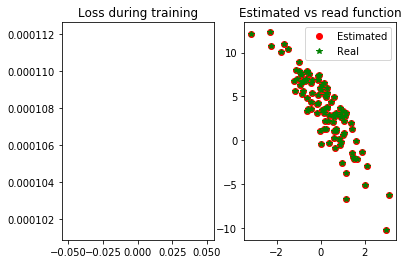

Epoch 1, batch 199. Moving avg of loss: 0.00010505310224850835. Average loss: 0.000104


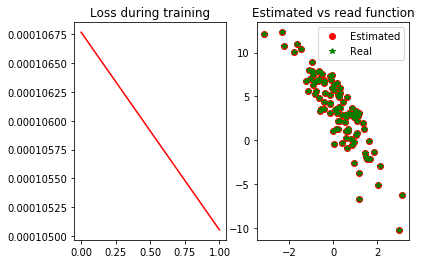

Epoch 2, batch 299. Moving avg of loss: 0.00010442385729402093. Average loss: 0.000104


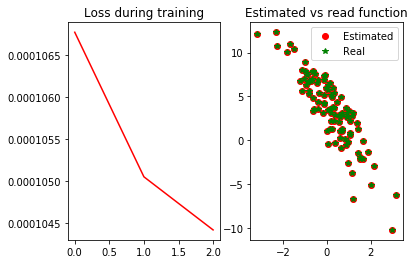

Epoch 3, batch 399. Moving avg of loss: 0.00010612321451627642. Average loss: 0.000105


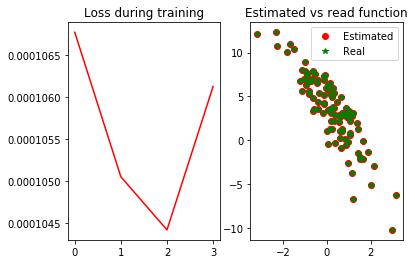

Epoch 4, batch 499. Moving avg of loss: 0.00010666137883092322. Average loss: 0.000104


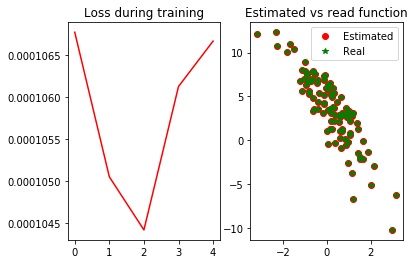

In [62]:
epochs = 5
learning_rate = 0.001
niter = 0
losses = []
moving_loss = 0
smoothing_constant = 0.01

#training
for e in range(epochs):
    total_loss = 0
    
    for data, label in data_iter():
        with autograd.record():
            output = net(data)
            loss = calc_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()
        
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss
        est_loss = moving_loss / (1 - (1 - smoothing_constant) ** niter)

        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" %(e, niter, est_loss, total_loss / num_examples))
            plot(losses, X)